In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from scipy.stats import shapiro
import matplotlib.pyplot as plt
from scipy.stats import norm, expon, lognorm, gamma, poisson
from fitter import Fitter, get_common_distributions, get_distributions

# load dataset 1

In [2]:
df = pd.read_csv('1_downloaded_data.csv', low_memory=False)

# 2 Action_taken and applicant_sex distribution

We want the distribution of the target variable: action_taken.

- 1 - Loan originated
- 2 - Application approved but not accepted
- 3 - Application denied
- 4 - Application withdrawn by applicant
- 5 - File closed for incompleteness
- 6 - Purchased loan
- 7 - Preapproval request denied
- 8 - Preapproval request approved but not accepted

An we also want the distibution of the applicant_sex variable.

- 1 - Male
- 2 - Female
- 3 - Information not provided by applicant in mail, internet, or telephone application
- 4 - Not applicable
- 6 - Applicant selected both male and female

In [3]:
df['action_taken'].value_counts()

action_taken
1    115661
4     41710
3     30623
6      8500
5      2104
2      1400
8         1
7         1
Name: count, dtype: int64

# Remove categories with less than 100 entries.

In [4]:
# Calculate the counts of each category in the "action_taken" column
action_taken_counts = df['action_taken'].value_counts()

# Remove categories with fewer than 100 entries
filtered_action_taken_counts = action_taken_counts[action_taken_counts >= 100]

# Filter the original DataFrame based on the filtered categories
df_filtered_action_taken = df[df['action_taken'].isin(filtered_action_taken_counts.index)].dropna(subset=['action_taken'])

# Check the new value counts for "action_taken"
print(df_filtered_action_taken['action_taken'].value_counts())

action_taken
1    115661
4     41710
3     30623
6      8500
5      2104
2      1400
Name: count, dtype: int64


In [5]:
df_filtered_action_taken['applicant_sex'].value_counts()

applicant_sex
1    124847
2     59555
3     11248
4      4248
6       100
Name: count, dtype: int64

# Remove anything except male, female and mixed gender.

In [6]:
# Remove rows where applicant_sex is 3 or 4, and also remove null values
df_filtered = df_filtered_action_taken[~df_filtered_action_taken['applicant_sex'].isin([3, 4])].dropna(subset=['applicant_sex'])

# Check the new value counts
print(df_filtered['applicant_sex'].value_counts())

applicant_sex
1    124847
2     59555
6       100
Name: count, dtype: int64


In [7]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 184502 entries, 0 to 199999
Data columns (total 99 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   activity_year                             184502 non-null  int64  
 1   lei                                       184502 non-null  object 
 2   derived_msa_md                            10558 non-null   float64
 3   state_code                                184444 non-null  object 
 4   county_code                               184434 non-null  float64
 5   census_tract                              184434 non-null  float64
 6   conforming_loan_limit                     184501 non-null  object 
 7   derived_loan_product_type                 184502 non-null  object 
 8   derived_dwelling_category                 184502 non-null  object 
 9   derived_ethnicity                         184502 non-null  object 
 10  derived_race             

## Plotting Histograms

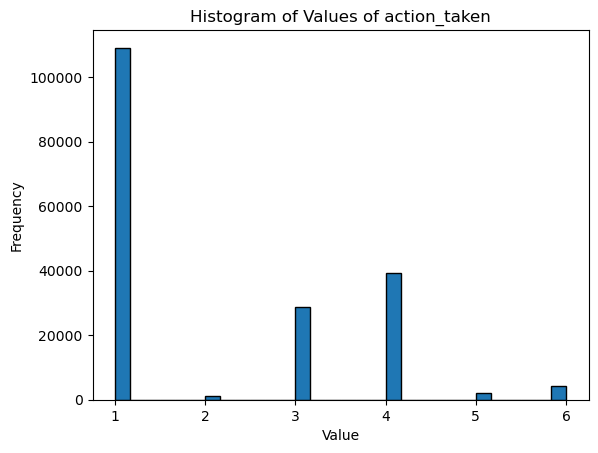

In [8]:
# Create a histogram on a logarithmic scale for the y-axis
plt.hist(df_filtered['action_taken'], bins=30, edgecolor='black', log=False)

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Values of action_taken')

# Show the plot
plt.show()

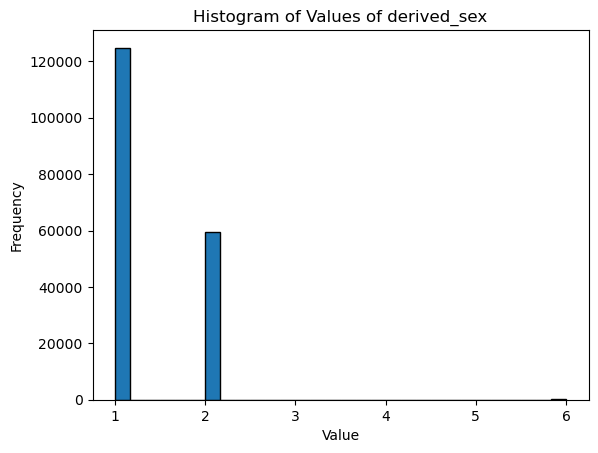

In [9]:
# Create a histogram on a logarithmic scale for the y-axis
plt.hist(df_filtered['applicant_sex'], bins=30, edgecolor='black', log=False)

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Values of derived_sex')

# Show the plot
plt.show()

### Shapiro-Wilk Test for Normality
assess if the combined data is normally distributed.

In [10]:
# Extract data for 'action_taken' and 'applicant_sex'
data_combined1 = df_filtered[['action_taken', 'applicant_sex']]

In [11]:
data_combined1.values

array([[3, 1],
       [2, 1],
       [5, 1],
       ...,
       [1, 2],
       [1, 1],
       [4, 1]], dtype=int64)

In [12]:
# Perform Shapiro-Wilk test
stat_combined1, p_value_combined1 = shapiro(data_combined1)

# Print the results
print('Shapiro-Wilk Test for Combined Data:')
print('  Statistic:', stat_combined1)
print('  p-value:', p_value_combined1)
print('  Is the data normally distributed?', p_value_combined1 > 0.05)


Shapiro-Wilk Test for Combined Data:
  Statistic: 0.6753749251365662
  p-value: 0.0
  Is the data normally distributed? False


C:\Users\asche\anaconda3\envs\Test\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


### Test for normal, exponential, poisson, gamma distribution

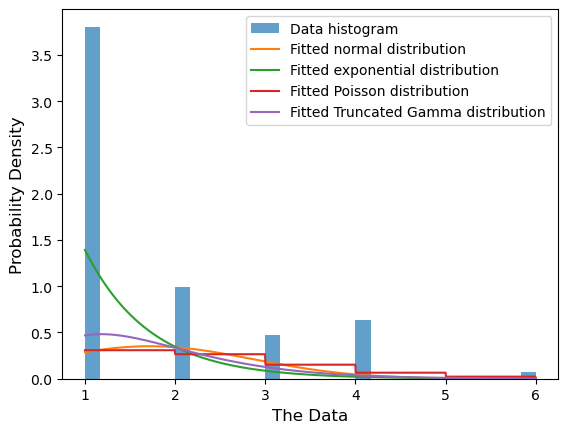

In [13]:
data = data_combined1[['action_taken', 'applicant_sex']].values

# Flatten the data into a 1D array
flattened_data = data.flatten()
flattened_data = flattened_data[flattened_data >= 0]  # Filter out negative or invalid values

# Fit the data to different distributions
params_norm = norm.fit(flattened_data)
params_expon = expon.fit(flattened_data)

# Generate x values for the PDFs
x = np.linspace(min(flattened_data), max(flattened_data), 1000)

# Fit the Poisson distribution
mu_poisson = np.mean(flattened_data)
pdf_poisson = poisson.pmf(x.astype(int), mu_poisson)

# Fit a truncated gamma distribution (truncated at 0 to avoid negative values)
a, loc, scale = gamma.fit(flattened_data, floc=0)
pdf_trunc_gamma = gamma.pdf(x, a, loc=0, scale=scale)

# Generate x values for the PDFs
x = np.linspace(min(flattened_data), max(flattened_data), 1000)
pdf_norm = norm.pdf(x, *params_norm)
pdf_expon = expon.pdf(x, *params_expon)

# Plot the data and fits
plt.hist(flattened_data, bins=30, density=True, alpha=0.7, label="Data histogram")
plt.plot(x, pdf_norm, label="Fitted normal distribution")
plt.plot(x, pdf_expon, label="Fitted exponential distribution")
plt.plot(x, pdf_poisson, label="Fitted Poisson distribution")
plt.plot(x, pdf_trunc_gamma, label="Fitted Truncated Gamma distribution")

plt.xlabel("The Data", fontsize=12)  # Adjust the fontsize here
plt.ylabel("Probability Density", fontsize=12)  # Adjust the fontsize here
plt.legend()
plt.legend(fontsize=10)  # Adjust the fontsize for the legend here
plt.xticks(fontsize=10)  # Adjust the fontsize for the x-axis ticks here
plt.yticks(fontsize=10)  # Adjust the fontsize for the y-axis ticks here

plt.show()

## Plotting Boxplots

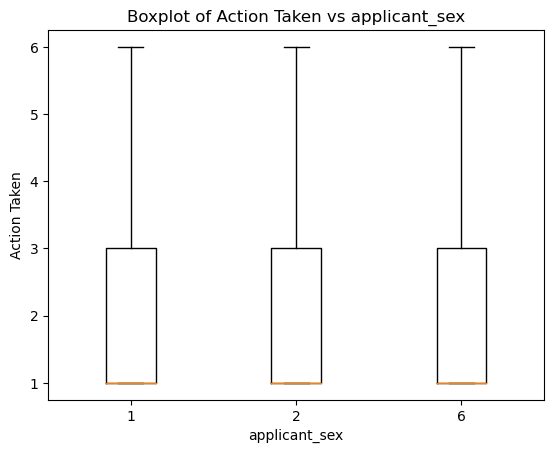

In [14]:
# Create a list of categories (unique values in 'derived_sex')
categories = df_filtered['applicant_sex'].unique()

# Initialize a list to store the data for each category
data_per_category = []

# Iterate over each category and extract the 'action_taken' values
for category in categories:
    data_per_category.append(df_filtered[df_filtered['applicant_sex'] == category]['action_taken'].values)

# Create a boxplot
plt.boxplot(data_per_category, labels=categories)

# Add labels and title
plt.xlabel('applicant_sex')
plt.ylabel('Action Taken')
plt.title('Boxplot of Action Taken vs applicant_sex')

# Show the plot
plt.show()


##  Barplot

C:\Users\asche\AppData\Local\Temp\ipykernel_20948\1090457474.py:9: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.histplot(binwidth=1,


<Axes: xlabel='action_taken', ylabel='Count'>

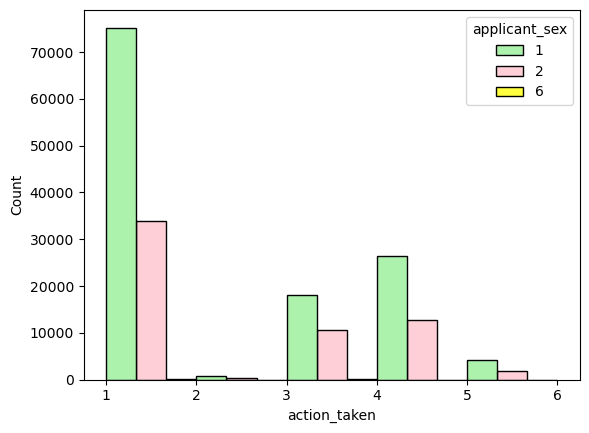

In [15]:
# Filter out the warnings related to is_categorical_dtype and use_inf_as_na
warnings.filterwarnings("ignore", message="is_categorical_dtype is deprecated")
warnings.filterwarnings("ignore", message="use_inf_as_na option is deprecated")

first_dimension = "action_taken"
horizontal_label = "x label"
second_dimension = "applicant_sex"

sns.histplot(binwidth=1,
            x= first_dimension,
            hue = second_dimension,
            data = df_filtered,
            stat = "count",
            multiple = "dodge",
            palette=['lightgreen', 'pink', 'yellow', 'orange', 'grey'])

In [16]:
df_test = df_filtered.copy()

# Group by 'action_taken' and 'applicant_sex' and count the occurrences
grouped_data = df_test.groupby(['action_taken', 'applicant_sex']).size().unstack().fillna(0)

# Calculate the total count of each 'action_taken' category
total_counts_action_taken = grouped_data.sum(axis=1)

# Calculate the percentages for each combination
percentage_data = grouped_data.divide(total_counts_action_taken, axis=0) * 100

# Print the percentage data
print("Percentage of each 'action_taken' category for each 'applicant_sex':")
print(percentage_data)

Percentage of each 'action_taken' category for each 'applicant_sex':
applicant_sex          1          2         6
action_taken                                 
1              68.931559  31.017140  0.051301
2              68.425197  31.574803  0.000000
3              63.000974  36.915530  0.083496
4              67.373464  32.583210  0.043325
5              67.153652  32.745592  0.100756
6              69.532392  30.443254  0.024355


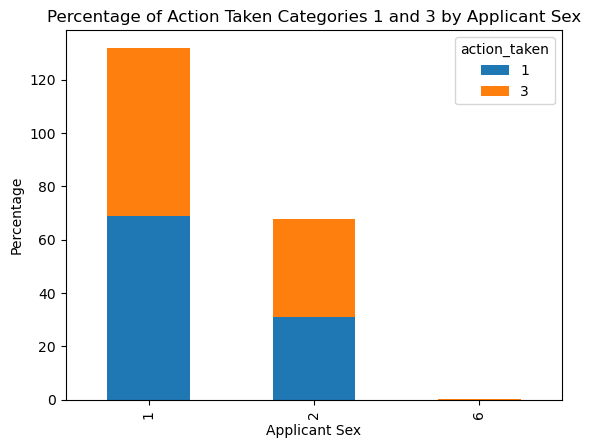

In [17]:

# Filter data for 'action_taken' categories 1 and 3
filtered_data = df_test[df_test['action_taken'].isin([1, 3])]

# Group by 'action_taken' and 'applicant_sex' and count the occurrences
grouped_data = filtered_data.groupby(['action_taken', 'applicant_sex']).size().unstack().fillna(0)

# Calculate the total count of each 'action_taken' category
total_counts_action_taken = grouped_data.sum(axis=1)

# Calculate the percentages for each combination
percentage_data = grouped_data.divide(total_counts_action_taken, axis=0) * 100

# Plot the percentages for 'action_taken' categories 1 and 3
percentage_data.loc[[1, 3]].T.plot(kind='bar', stacked=True)

# Add labels and title
plt.xlabel('Applicant Sex')
plt.ylabel('Percentage')
plt.title('Percentage of Action Taken Categories 1 and 3 by Applicant Sex')

# Show the plot
plt.show()

# Conclusion

The exponential distribution is often used to model the time until an event occurs in a Poisson process, which could be related to the time until a loan is approved or some other event.


- Data: Sex and loan approval (action taken category).

- Distribution: Exponential distribution, modeling the time until loan approval.

- Interpretation: The exponential distribution suggests that the time (or other relevant measure) until a loan is approved may follow this distribution. The rate parameter of the exponential distribution (often denoted as λ, which is the reciprocal of the mean) provides an estimate of how frequently loans are approved.

In [18]:
import numpy as np

# Filter data for applicant_sex category 1 and action_taken category 1
data_applicant_sex_1_action_taken_1 = df_test[df_test['applicant_sex'] == 1]['action_taken']

# Calculate the mean of the filtered data
mean_of_data_applicant_sex_1_action_taken_1 = np.mean(data_applicant_sex_1_action_taken_1)

# Calculate the rate parameter (lambda) for applicant_sex category 1 and action_taken category 1
rate_parameter_applicant_sex_1_action_taken_1 = 1 / mean_of_data_applicant_sex_1_action_taken_1

print("Rate parameter (lambda) for the exponential distribution, applicant_sex category 1 and action_taken:", rate_parameter_applicant_sex_1_action_taken_1)

Rate parameter (lambda) for the exponential distribution, applicant_sex category 1 and action_taken: 0.4786178977109362


In [19]:
import numpy as np

# Filter data for applicant_sex category 1 and action_taken category 1
data_applicant_sex_2_action_taken_1 = df_test[df_test['applicant_sex'] == 2]['action_taken']

# Calculate the mean of the filtered data
mean_of_data_applicant_sex_2_action_taken_1 = np.mean(data_applicant_sex_2_action_taken_1)

# Calculate the rate parameter (lambda) for applicant_sex category 1 and action_taken category 1
rate_parameter_applicant_sex_2_action_taken_1 = 1 / mean_of_data_applicant_sex_2_action_taken_1

print("Rate parameter (lambda) for the exponential distribution, applicant_sex category 2 and action_taken:", rate_parameter_applicant_sex_2_action_taken_1)


Rate parameter (lambda) for the exponential distribution, applicant_sex category 2 and action_taken: 0.4638854053885639


In [20]:
df_test.to_csv('2_distribution_applicant_sex_and_action_taken.csv', index=False)